## Ejercicio cross-validation
<li>
<ul>Considere una variable $x\sim U(0,10)$ y genere $n=100$ muestras de $x$.</ul>
<ul>Considere $y=3x+2+\varepsilon$ donde $\varepsilon\sim N(0,1)$ y genere 100 muestras a partir de las anteriores.</ul>
</li>



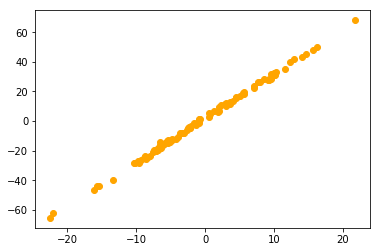

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed_ = 104
np.random.seed(seed_)

x = np.random.normal(loc = 0, scale = 10, size = 100)
y = 3*x + 2 + np.random.normal(loc = 0, scale=1, size = 100)
plt.scatter(x, y, color ='orange')

#### Evalúe
<br> Seleccione el $80\%$ de los pares $(x,y)$ en un conjunto $TRAIN$ y el $20\%$ restante en $TEST$.<br>
<br> Use los datos en $TRAIN$ para ajustar regresiones lineales de grado $0, 1, \ldots, 25$ y el otro conjunto para evaluar el error cuadrático medio. <br>

In [2]:
#forma manual de separar los datos:
xy = np.c_[x, y]
np.random.shuffle(xy)
train = xy[:int(0.8*xy.shape[0])]
test = xy[int(0.8*xy.shape[0]):]

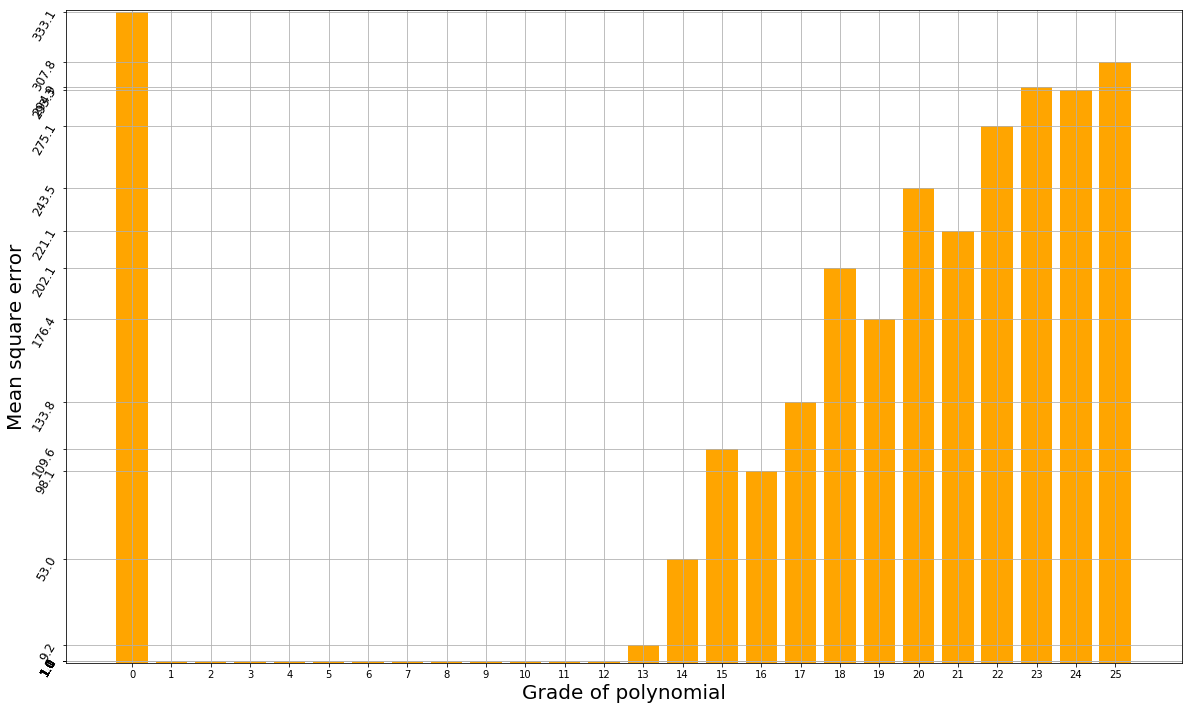

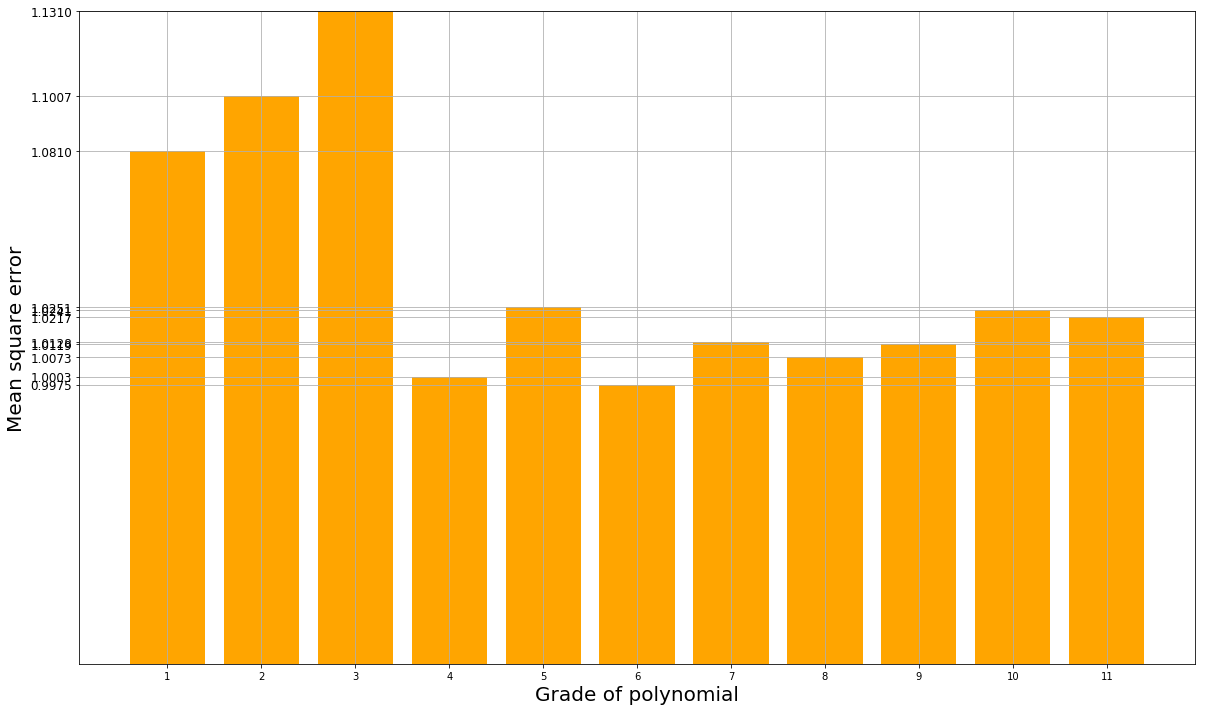

In [3]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

mse_er_l = list()
l_reg = LinearRegression()

grades = range(0,26)
for grade in grades:
    vander_train = np.vander(train[:,0], N = grade+1) #np.vander(N=, X=) donde N es la cantidad de columnas de la matriz de Vandermonde, N = orden del polinomio+1
    l_reg.fit(vander_train, train[:,1])
    vander_test = np.vander(test[:,0], N = grade+1)
    predict = l_reg.predict(vander_test)
    mse = mean_squared_error(y_true = test[:,1], y_pred = predict)
    mse_er_l = np.append(mse_er_l, mse)

fig1 = plt.figure(figsize=(20,12))
plt.bar(range(0,26), mse_er_l, color = 'orange')
plt.ylim(ymin=min(mse_er_l)-1, ymax=max(mse_er_l)+1)
plt.grid(True)
plt.xticks(range(0,26));
plt.yticks(mse_er_l, rotation = 60, size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);

fig2 = plt.figure(figsize=(20,12))
plt.bar(range(1,12), mse_er_l[1:12], color = 'orange')
plt.grid(True)
plt.ylim(ymin=min(mse_er_l[1:12])-0.1, ymax=max(mse_er_l[1:12]))
plt.xticks(range(1, 12));
plt.yticks(mse_er_l[1:12], size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);

<br>Qué modelo da mejor? <br>

In [4]:
print('El polinomio que menor error cuadratico tiene es el de grado {0}, con MSE {1}'.format(mse_er_l.argmin(), mse_er_l.min()))

El polinomio que menor error cuadratico tiene es el de grado 6, con MSE 0.997490048962091


<br>Esto no significa que sea el mejor modelo para predecir los datos, porque los datos de test puede que sean muy similares a los de train y el modelo este sobreajustando a los datos de train, por ello el error es pequeño.<br>

<br>Repita 100 veces la generacion de muestras y selección de modelo: Da siempre el mismo resultado? <br> 

In [5]:
def make_random_data(seed_, size_, mean, std):
    np.random.seed(seed_)
    x = np.random.normal(loc = mean, scale = std, size = size_)
    y = 3*x + 2 + np.random.normal(loc = 0, scale = 1, size = size_)
    xy = np.c_[x,y]
    return xy

def split_data(xy, train_size):
    np.random.shuffle(xy)
    train = xy[:int(train_size*xy.shape[0])]
    test = xy[int(train_size*xy.shape[0]):]
    return train, test

Grado de los polinomios con menor error [ 1.  2.  3.  4.  5.  6.  8. 10. 11. 12.]


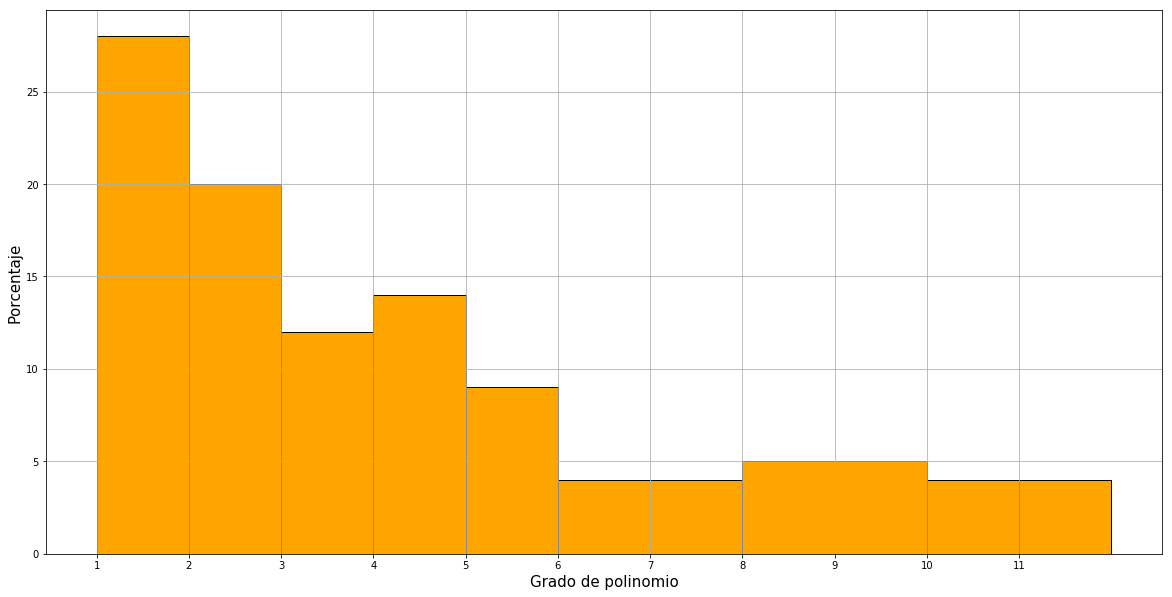

In [6]:
import seaborn as sns

polynomial_grade_selected_l = list()

for counter in range(0,100):
    xy = make_random_data(seed_ = counter, size_ = 100, mean = 0, std = 10)
    train, test = split_data(xy, train_size = 0.8)
    
    mse_er_l = list()
    l_reg = LinearRegression()
    for grade in grades:
        vander_train = np.vander(train[:,0], N = grade+1)
        l_reg.fit(vander_train, train[:,1])
        vander_test = np.vander(test[:,0], N = grade+1)
        predict = l_reg.predict(vander_test)
        mse = mean_squared_error(y_true = test[:,1], y_pred = predict)
        mse_er_l = np.append(mse_er_l, mse)
    
    polynomial_grade_selected_l = np.append(polynomial_grade_selected_l, mse_er_l.argmin())
    
print('Grado de los polinomios con menor error {0}'.format(np.unique(polynomial_grade_selected_l)))
plt.figure(figsize=(20,10))
plt.hist(polynomial_grade_selected_l, color = 'orange', bins=np.unique(polynomial_grade_selected_l), edgecolor='black')
plt.xticks(range(int(min(polynomial_grade_selected_l)), int(max(polynomial_grade_selected_l))));
plt.grid(True)
plt.ylabel('Porcentaje', size = 15);
plt.xlabel('Grado de polinomio', size = 15);

<br>El modelo con menor error no va a ser siempre el mismo, ya que para cada muestra se van a generar datos diferentes (se cambia la seed de numpy.random), que pueden ser mejor predecidos por modelos de diferente orden.<br>
<br>En el gráfico se ve que para las 100 muestras diferentes, el modelo mas elegido es el de orden 1.<br>

#### Parta el conjunto original de 100 pares en $k\in\mathbf{N} \textit{folds}$ . 
<br> Seleccione un fold $F$ y use los demás para ajustar una regresión y el fold $F$ para evaluar el error cometido $E_F$.<br>

In [7]:
def split_k_folds (xy, k, fold_test):
    #Esta funcion separa x e y en k folds y luego devuelve el fold_train como test set, y el resto de los folds los junta en un train set.
    h = round(xy.shape[0]/k)
    folds = list()
    
    for i in range(k):
        if i == k-1:
            fold = xy[h*i:]
        else:
            fold = xy[h*i:h*(i+1)]
        folds.append(fold)
        
    folds = np.array(folds)            
    test = folds[fold_test-1]
    folds_remaining = np.delete(folds, fold_test-1, axis = 0)
    
    x_train = list()
    y_train = list()
    for fold in folds_remaining:
        x_=fold[:,0]
        y_=fold[:,1]
        x_train = np.append(x_train, x_)
        y_train = np.append(y_train, y_)
    train = np.c_[x_train, y_train]

    return train, test

El error de la regresión de grado 1 es 1.4568789472179098


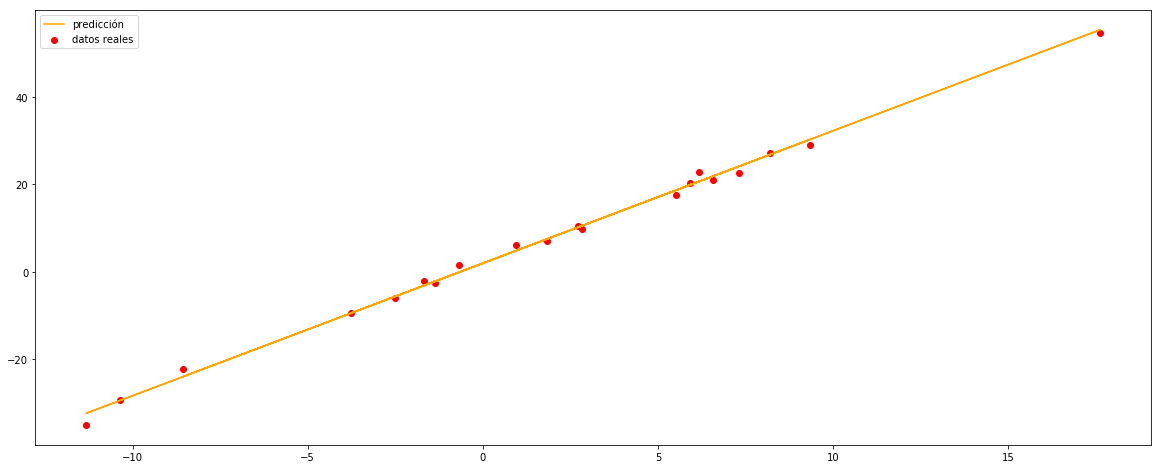

In [8]:
train, test = split_k_folds(xy, k = 5, fold_test = 0)

l_reg = LinearRegression()
grade = 1
l_reg.fit(np.vander(N=grade+1, x=train[:,0]), train[:,1])
pred = l_reg.predict(np.vander(N=grade+1, x=test[:,0]))
print('El error de la regresión de grado {0} es {1}'.format(grade, mean_squared_error(pred, test[:,1])))

plt.figure(figsize=(20,8))
plt.scatter(test[:,0], test[:,1], color = 'red')
plt.plot(test[:,0], pred, color = 'orange')
plt.legend(['predicción', 'datos reales']);

<br> Repita para regresiones lineales de diferente grado, como antes.<br>


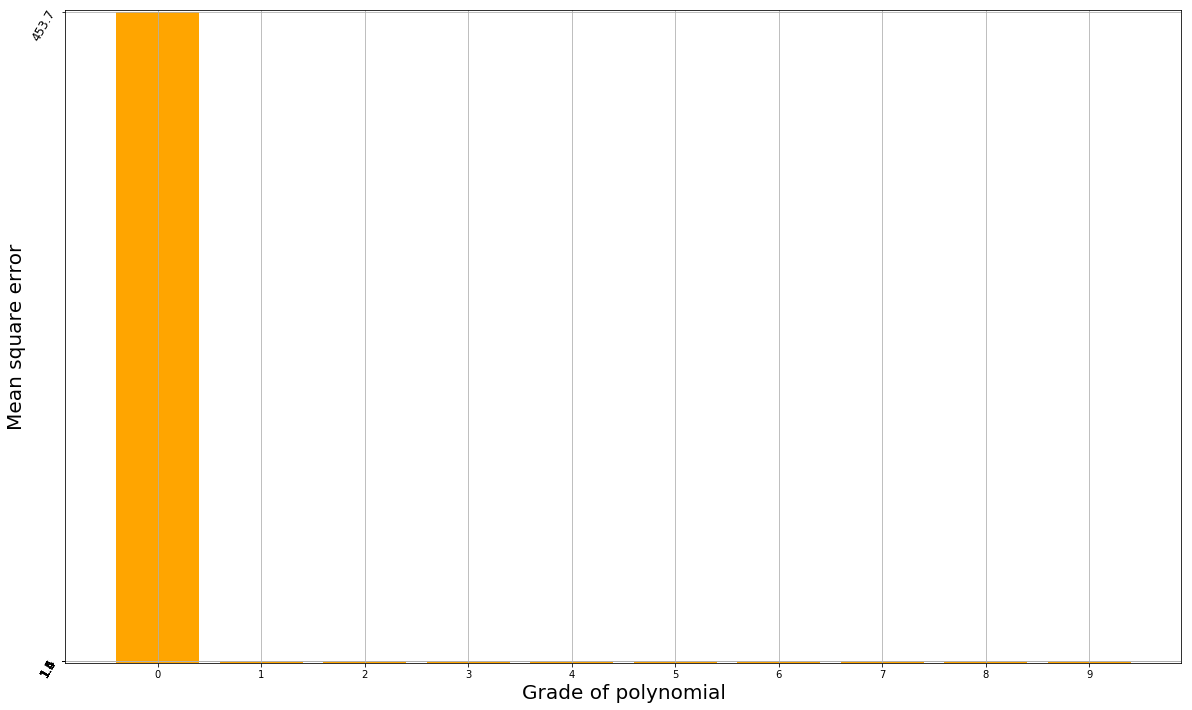

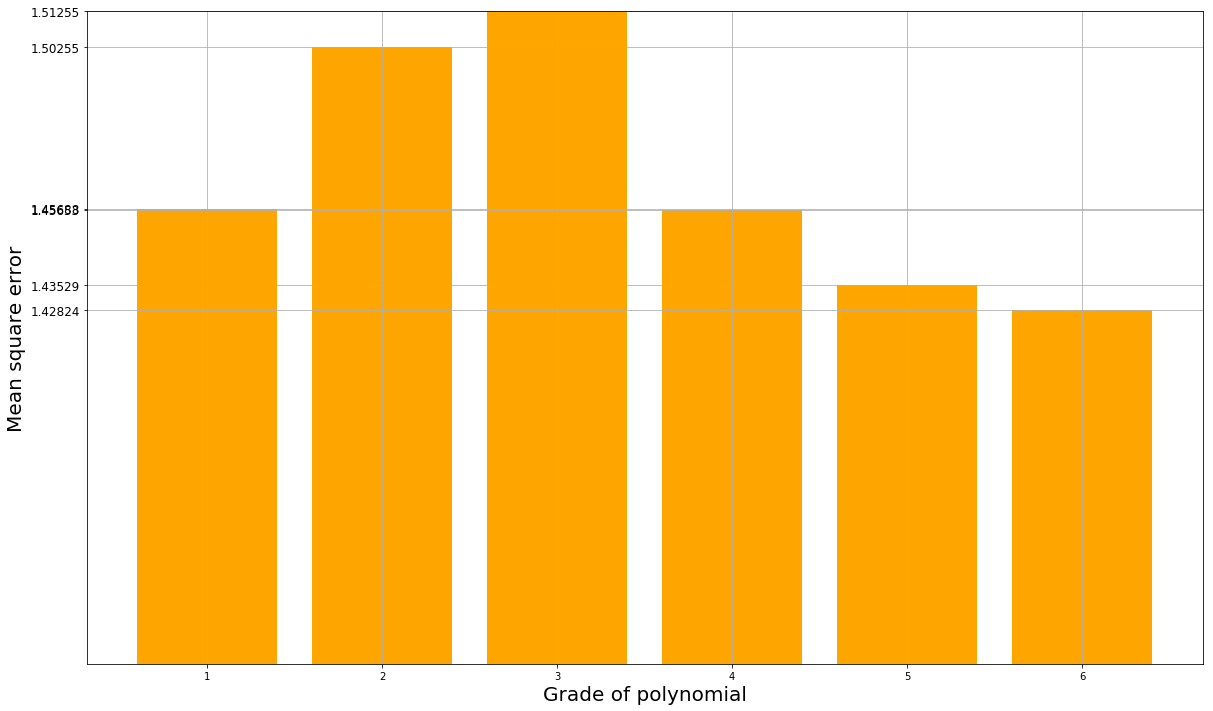

In [9]:
mse_l = list()
grades = range(0,10)
for grade in grades:
    vander_train = np.vander(train[:,0], N=grade+1)
    l_reg.fit(vander_train, train[:,1])
    vander_test = np.vander(test[:,0], N=grade+1, )
    predict = l_reg.predict(vander_test)
    mse = mean_squared_error(predict, test[:,1])
    mse_l = np.append(mse_l, mse)
    
fig1 = plt.figure(figsize=(20,12))
plt.bar(grades, mse_l, color = 'orange')
plt.ylim(ymin=min(mse_l)-1, ymax=max(mse_l)+1)
plt.xticks(grades);
plt.yticks(mse_l, rotation = 60, size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);
plt.grid(True)

fig2 = plt.figure(figsize=(20,12))
plt.bar(grades[1:7], mse_l[1:7], color = 'orange')
plt.ylim(ymin=min(mse_l[1:7])-0.1, ymax=max(mse_l[1:7]))
plt.xticks(grades[1:7]);
plt.yticks(mse_l[1:7], size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);
plt.grid(True)

<br> Calcule el error medio $\sum_F \frac {E_F} k$ cuando $F$ recorre todos los folds.<br>

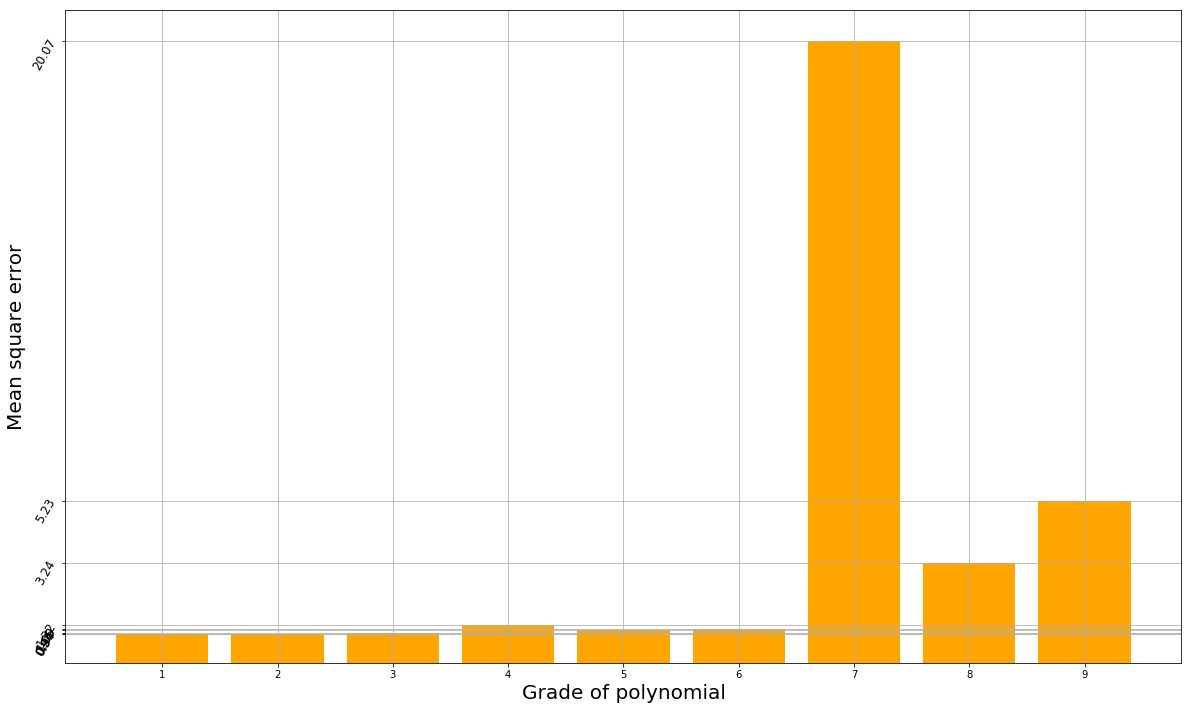

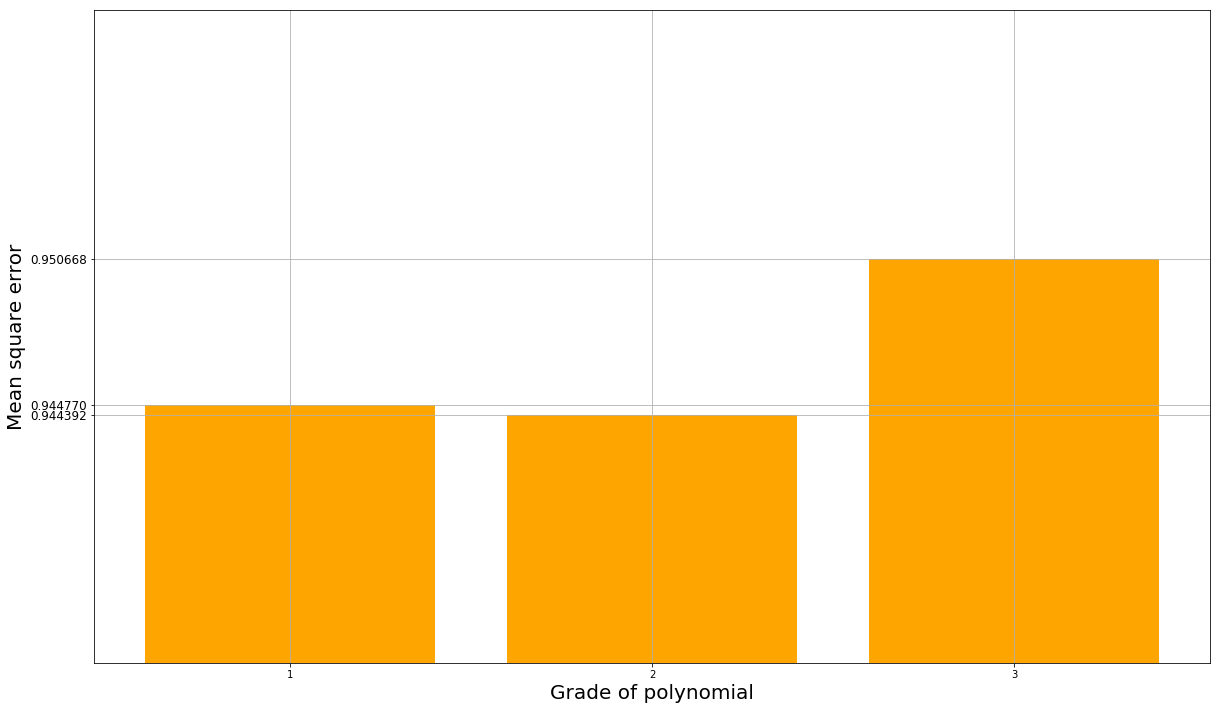

In [23]:
k=5
grades = range(1,10)
l_reg = LinearRegression()

mse_means = list()
for grade in grades:
    mse_l = list()
    for fold_to_test in range(1,k+1):
        train, test = split_k_folds(xy, k, fold_test=fold_to_test)
        vander_train = np.vander(train[:,0], N=grade+1)
        l_reg.fit(vander_train, train[:,1])
        vander_test = np.vander(test[:,0], N=grade+1)
        predict = l_reg.predict(vander_test)
        mse = mean_squared_error(predict, test[:,1])
        mse_l = np.append(mse_l, mse)
    mse_means = np.append(mse_means, mse_l.mean())

plt.figure(figsize=(20,12))
plt.bar(grades, mse_means, color = 'orange')
plt.ylim(ymin=0, ymax=max(mse_means)+1)
plt.xticks(grades);
plt.yticks(mse_means, rotation = 60, size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);
plt.grid(True)

plt.figure(figsize=(20,12))
plt.bar(grades[:3], mse_means[:3], color='orange')
plt.ylim(ymin=min(mse_means[:3])-0.01, ymax=max(mse_means[:3])+0.01)
plt.xticks(grades[:3]);
plt.yticks(mse_means[:3], size = 12);
plt.xlabel('Grade of polynomial', size = 20)
plt.ylabel('Mean square error', size = 20);
plt.grid(True)

<br>Para $k=5$, ¿qué modelo da mejor?<br>

In [25]:
print('Para k = {0} el modelo que menor error tiene, recorriendo todos los folds es el de grado {1} con MSE = {2}'.format(k, mse_means.argmin()+1, mse_means.min()))

Para k = 5 el modelo que menor error tiene, recorriendo todos los folds es el de grado 2 con MSE = 0.9443919996748203


<br> Repita 100 veces la generacion de muestras y selección de modelo: Da siempre el mismo resultado?<br>


In [38]:
grades = range(10)
models_choosen_l = list()
k = 5
l_reg = LinearRegression()

for i in range(100):
    xy = make_random_data(mean=0, seed_=i, size_=100, std=10)
    mse_means = list()
    for grade in grades: #genera los modelos de distinto orden para cada una de las 100 muestras diferentes
        mse_l = list()
        for fold_to_test in range(1,k+1): #Prueba el modelo de grado = 'grade' en los k folds
            train, test = split_k_folds(xy, k, fold_test=fold_to_test)
            vander_train = np.vander(train[:,0], N=grade+1)
            l_reg.fit(vander_train, train[:,1])
            vander_test = np.vander(test[:,0], N=grade+1)
            predict = l_reg.predict(vander_test)
            mse = mean_squared_error(predict, test[:,1])
            mse_l = np.append(mse_l, mse)
        mse_means = np.append(mse_means, mse_l.mean())
    models_choosen_l = np.append(models_choosen_l, mse_means.argmin())
print('Los modelos elegidos para cada una de las 100 muestras generadas son los de orden : {0}'.format(models_choosen_l))

Los modelos elegidos para cada una de las 100 muestras generadas son los de orden : [1. 4. 2. 2. 2. 1. 2. 3. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 5. 1. 2. 6. 2. 2.
 2. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 3. 1. 4. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1.
 2. 4. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 4. 2. 4. 4. 1. 1. 1. 1. 1. 6. 2.
 2. 1. 3. 1. 1. 1. 1. 1. 3. 1. 1. 4. 1. 1. 1. 1. 1. 3. 1. 9. 2. 5. 1. 2.
 1. 1. 1. 1.]


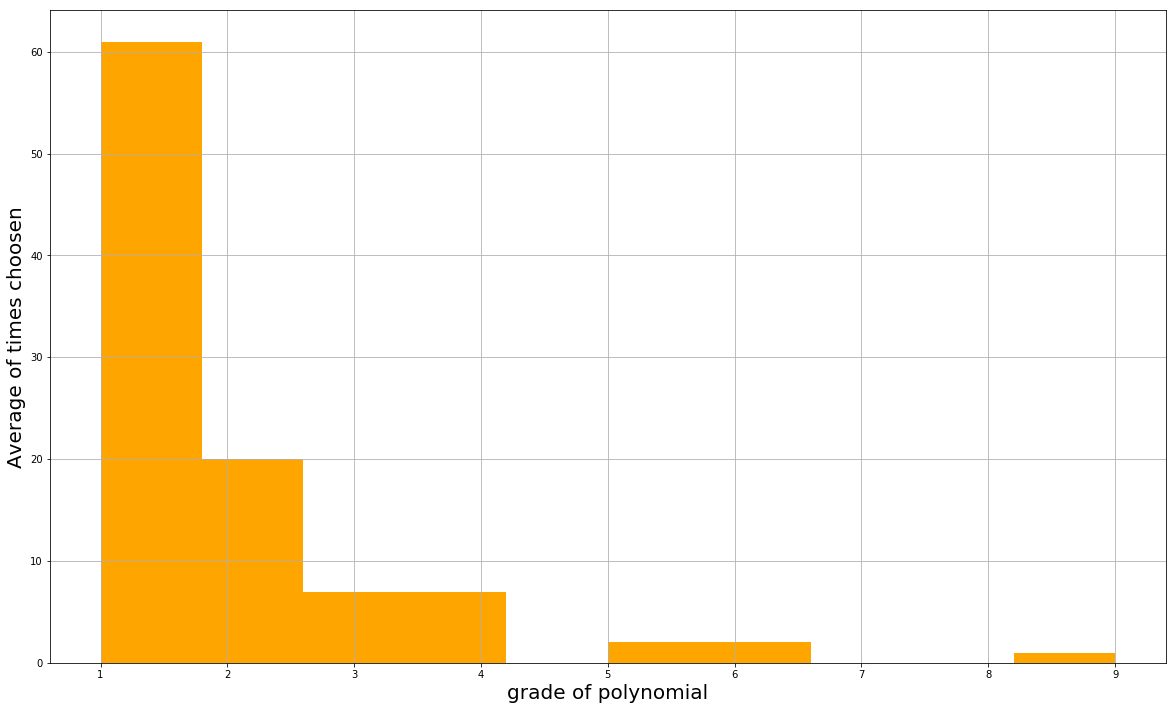

In [40]:
plt.figure(figsize=(20,12))
plt.hist(models_choosen_l, color='orange')
plt.grid(True)
plt.xlabel('grade of polynomial', size=20);
plt.ylabel('Average of times choosen', size=20);

En cada una de las 100 iteraciones no da el mismo resultado, pero en promedio, el mas elegido es el modelo de orden 1.

#### En el caso $k=n$ cada fold tiene un solo elemento. 
<li>
<ul> Reescriba el código de forma de optimizarlo para este caso particular.</ul>
<ul> Repita el ejercicio anterior para $k=n$.</ul>
</li>

In [42]:
grades = range(4)
data_size = 100
models_choosen_l = list()
k = data_size
l_reg = LinearRegression()

for i in range(data_size):
    xy = make_random_data(mean=0, seed_=i, size_=data_size, std=10)
    mse_means = list()
    for grade in grades: #genera los modelos de distinto orden para cada una de las 100 muestras diferentes
        mse_l = list()
        for fold_to_test in range(1,k+1): #Prueba el modelo de grado = 'grade' en los k folds
            train, test = split_k_folds(xy, k, fold_test=fold_to_test)
            vander_train = np.vander(train[:,0], N=grade+1)
            l_reg.fit(vander_train, train[:,1])
            vander_test = np.vander(test[:,0], N=grade+1)
            predict = l_reg.predict(vander_test)
            mse = mean_squared_error(predict, test[:,1])
            mse_l = np.append(mse_l, mse)
        mse_means = np.append(mse_means, mse_l.mean())
    models_choosen_l = np.append(models_choosen_l, mse_means.argmin())
print('Los modelos elegidos para cada una de las 100 muestras generadas son los de orden : {0}'.format(models_choosen_l))

Los modelos elegidos para cada una de las 100 muestras generadas son los de orden : [1. 1. 2. 3. 2. 1. 2. 3. 1. 1. 1. 3. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1.
 1. 1. 2. 1. 2. 1. 3. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 2. 1. 1. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 2. 1. 1.
 1. 1. 1. 1.]


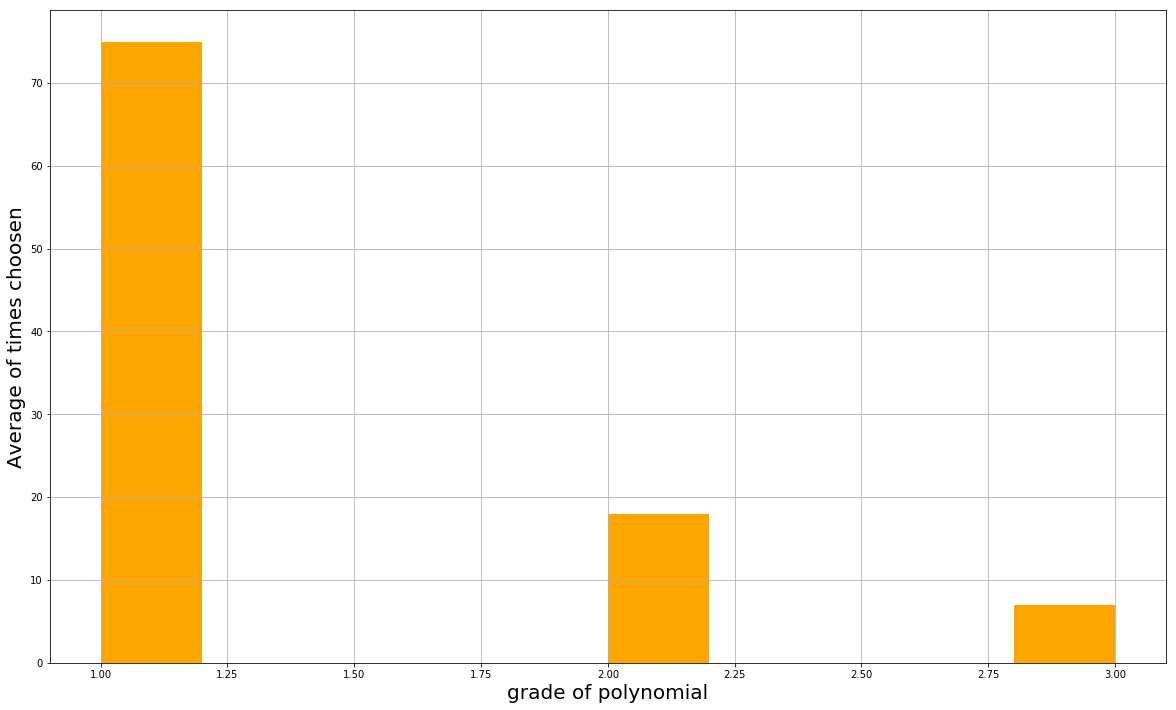

In [43]:
plt.figure(figsize=(20,12))
plt.hist(models_choosen_l, color='orange')
plt.grid(True)
plt.xlabel('grade of polynomial', size=20);
plt.ylabel('Average of times choosen', size=20);

Se eligió solamente entre 3 ordenes de modelo porque el algoritmo es muy costoso computacionalmente. Igualmente, se ve que se elige el modelo de orden 1 en la mayoria de los casos.